In [ ]:
################################################################################
########################          Yelp Reviews          ######################## 
########################    Classification : lightGBM   ######################## 
########################  Stars on Reviews: 1 & 2 vs 5  ########################
################################################################################

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM


In [ ]:
# Clone lightGBM
! git clone --recursive https://github.com/Microsoft/LightGBM

fatal: destination path 'LightGBM' already exists and is not an empty directory.


In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM

! mkdir build

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM
mkdir: cannot create directory ‘build’: File exists


In [ ]:
# Compile
! cmake -DUSE_GPU=1 #avoid ..
! make -j$(nproc)

CMake Warning:
  No source or binary directory provided.  Both will be assumed to be the
  same as the current working directory, but note that this warning will
  become a fatal error in future CMake releases.


CMake Error: The current CMakeCache.txt directory /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM/CMakeCache.txt is different than the directory /content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/LightGBM where CMakeCache.txt was created. This may result in binaries being created in the wrong place. If you are not sure, reedit the CMakeCache.txt
CMake Error: The source "/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM/CMakeLists.txt" does not match the source "/content/drive/MyDrive/UsedCarsCarGurus/ML/lightGBM/LightGBM/CMakeLists.txt" used to generate cache.  Re-run cmake with a different source directory.
-- OpenCL include directory: /usr/include
-- Using _mm_prefetch
-- Using _mm_malloc
-- Configuring done
-- Generating done
-

In [ ]:
! sudo apt-get -y install python-pip

! sudo -H pip install setuptools numpy pandas scikit-learn sklearn joblib optuna gensim==3.8.3 datetime plotly matplotlib==3.4.2 seaborn -U

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-pip is already the newest version (9.0.1-2.3~ubuntu1.18.04.5).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM/python-package

! sudo python3 setup.py install --precompile --gpu

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/LightGBM/python-package
running install
/usr/local/lib/python3.7/dist-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,
running build
running build_py
running egg_info
writing lightgbm.egg-info/PKG-INFO
writing dependency_links to lightgbm.egg-info/dependency_links.txt
writing requirements to lightgbm.egg-info/requires.txt
writing top-level names to lightgbm.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
no previously-included directories found matching 'build'
writing manifest file 'lightgbm.egg-info/SOURCES.txt'
copying lightgbm/VERSION.txt -> build/lib/lightgbm
running install_lib
copying build/lib/lightgbm/VERSION.txt -> /usr/lib/python3.7/site-packages/lightgbm
INFO:LightGBM:Installing lib_lightgbm from: ['/content/drive/MyDrive/Yelp_Reviews/ML/Classificati

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim import models
import multiprocessing
import pickle
import joblib
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from lightgbm import LGBMClassifier
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) # use INFO to see progress
from optuna.integration import LightGBMPruningCallback
import joblib
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

my_dpi=96

In [ ]:
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

print('\n')
cores = multiprocessing.cpu_count()
print('Number of cores:', cores)

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Fri May 13 19:21:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|            

In [ ]:
# Set seed 
seed_value = 42
os.environ['YelpReviews_ML'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

/content/drive/MyDrive/Yelp_Reviews/Data


In [ ]:
# Read tokenized reviews with stars filtered to 1, 2 and 5
df = pd.read_parquet('YelpReviews_NLP_125stars_tokenized.parquet')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (1541486, 2)


,stars_reviews,cleanReview
index,,
2,5.0,"[wonderful, place, get, lunch, staff, friendly..."
3,5.0,"[dedicated, loving, memory, gary, feldman, gre..."
5,5.0,"[love, place, everything, menu, delicious, lik..."
7,5.0,"[truely, hidden, gem, place, greatest, buffalo..."
9,5.0,"[seriously, great, fresh, fantastic, food, spo..."


In [ ]:
# Process format of reviews for word2vec
df = df.copy()
df["cleanReview"]= [[f'"{j}"' for j in i] for i in df["cleanReview"]]
df.head()

,stars_reviews,cleanReview
index,,
2,5.0,"[""wonderful"", ""place"", ""get"", ""lunch"", ""staff""..."
3,5.0,"[""dedicated"", ""loving"", ""memory"", ""gary"", ""fel..."
5,5.0,"[""love"", ""place"", ""everything"", ""menu"", ""delic..."
7,5.0,"[""truely"", ""hidden"", ""gem"", ""place"", ""greatest..."
9,5.0,"[""seriously"", ""great"", ""fresh"", ""fantastic"", ""..."


In [ ]:
# Recode to binary
df = df.copy()
df['stars_reviews'].mask(df['stars_reviews'] == 1, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 2, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 5, 1, inplace=True)

print('Number of reviews per group:')
df[['stars_reviews']].value_counts() 

Number of reviews per group:


stars_reviews
0.0              770743
1.0              770743
dtype: int64

In [ ]:
df1 = df[df.stars_reviews==0]
df1 = shuffle(df1)
df1 = df1.sample(n=414937)

In [ ]:
df2 = df[df.stars_reviews==1]
df2 = shuffle(df2)
df2 = df2.sample(n=414937)
df = pd.concat([df1, df2])
df = shuffle(df)

del df1, df2

df.shape

(829874, 2)

In [ ]:
# Set up label and features
label = df[['stars_reviews']]
features = df.cleanReview

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [ ]:
# Load model
word2vec_path = 'gensim_w2vModel_review125_50epochs.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
# Save embedded word vector space
wv = model.wv
print(len(wv.vocab),'unique words in the dataset.')

373847 unique words in the dataset.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



In [ ]:
# Creating Mean Word Embeddings using Mean Embedding Vectorizer class
class W2vVectorizer(object):
    """
    This class is used to provide mean word vectors for review documents. 
    This is done in the transform function which is used to generate mean vectors in model pipelines.
    The class has both fit and transform functions so that it may be used in an sklearn Pipeline.
    """
    
    def __init__(self, w2v):
        self.w2v = w2v
        
        #If using GloVe the model is in a dictionary format
        if isinstance(w2v, dict):
            if len(w2v) == 0:
                self.dimensions = 0
            else:
                self.dimensions = len(w2v[next(iter(w2v))])
        #Otherwise, using gensim keyed vector
        else:
            self.dimensions = w2v.vector_size
    
    # Need to implement a fit method as required for sklearn Pipeline.
    def fit(self, X, y):
        return self

    def transform(self, X):
        """
        This function generates a w2v vector for a set of tokens. This is done by taking 
        the mean of each token in the review.
        """
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                    or [np.zeros(self.dimensions)], axis=0) for words in X])

In [ ]:
print('Pipeline for Word2Vec:')
pl  = Pipeline([("W2vVectorizer", W2vVectorizer(wv))])
pl

Pipeline for Word2Vec:


Pipeline(steps=[('W2vVectorizer',
                 <__main__.W2vVectorizer object at 0x7f4882bff850>)])

In [ ]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/ReviewStars/Model_PKL/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/ReviewStars/Model_PKL


In [ ]:
def train_model_for_study(features, label, model):
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        label, 
        test_size=0.2, 
        stratify=label,
        random_state=seed_value
    )

    X_train = pl.fit_transform(X_train)
    X_test = pl.fit_transform(X_test)
    
    # Start timer for each trial
    start = timer()

    model.fit(
        X_train, 
        y_train.values.ravel(),
        eval_set=[(X_test, y_test.values.ravel())])

    # Predictions
    y_pred_val = model.predict_proba(X_test)
    cv_scores = log_loss(y_test, y_pred_val)     
    print('- Validation logloss:', np.mean(cv_scores))  
    run_time = timer() - start

    return np.mean(cv_scores)       

In [ ]:
################################################################################
######################     lightGBM Optuna HPO  ################################
######################         100 trials       ################################
################################################################################
def lgb_hpo(trial):
    """
    Objective function to tune a `LGBMClassifier` model.
    """
    joblib.dump(study, 'lightGBM_Optuna_100_GPU_balancedSizeSentiment.pkl')

    # Define parameter grid
    params_lgb_optuna = {
        'random_state': seed_value,
        'device_type':'gpu',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.000001,0.1),
        'num_leaves': trial.suggest_int('num_leaves', 100, 1000, step=20),
        
        'bagging_freq': trial.suggest_int('bagging_freq', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 0.95),

        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9),

        'max_depth': trial.suggest_int('max_depth', 3, 12),

        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 1e-1, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 1e-1,  log=True),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 100, 500, step=10),       

        'verbosity': -1
    }
    
    model = lgb.LGBMClassifier(**params_lgb_optuna, early_stopping_rounds=150)

    return train_model_for_study(features, label, model)


In [ ]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
if os.path.isfile('lightGBM_Optuna_100_GPU_balancedSizeSentiment.pkl'):
    study = joblib.load('lightGBM_Optuna_100_GPU_balancedSizeSentiment.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(lgb_hpo, n_trials=2)

# End timer for experiment
end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Start Time           2022-05-13 19:09:27.660707
[LightGBM] [Warning] lambda_l2 is set=6.004088321275922e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.004088321275922e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] early_stopping_round is set=150, early_stopping_rounds=150 will be ignored. Current value: early_stopping_round=150
[LightGBM] [Warning] lambda_l1 is set=5.541795033541325e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.541795033541325e-08
[LightGBM] [Warning] min_gain_to_split is set=0.7797243481269726, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7797243481269726
- Validation logloss: 0.6474538317163476
- Validation logloss: 0.15613514660760613
Start Time           2022-05-13 19:09:27.660707
End Time             2022-05-13 19:14:25.347940
0:04:57


Number of finished trials: 100
Best trial: {'n_estimators': 490, 'learning_rate': 0

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/ReviewStars/trialOptions/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/ReviewStars/trialOptions


In [ ]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'logloss'},inplace=True)
trials_df.rename(columns={'params_bagging_freq':'bagging_freq'}, inplace=True)
trials_df.rename(columns={'params_colsample_bytree':'colsample_bytree'}, inplace=True)
trials_df.rename(columns={'params_lambda_l1':'lambda_l1'}, inplace=True)
trials_df.rename(columns={'params_lambda_l2':'lambda_l2'}, inplace=True)
trials_df.rename(columns={'params_learning_rate':'learning_rate'}, inplace=True)
trials_df.rename(columns={'params_max_depth':'max_depth'}, inplace=True)
trials_df.rename(columns={'params_min_child_samples':'min_child_samples'}, inplace=True)
trials_df.rename(columns={'params_min_gain_to_split':'min_gain_to_split'}, inplace=True)
trials_df.rename(columns={'params_n_estimators':'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_num_leaves':'num_leaves'}, inplace=True)
trials_df.rename(columns={'params_subsample':'subsample'}, inplace=True)
trials_df = trials_df.sort_values('logloss', ascending=True)
trials_df = trials_df[trials_df['logloss'].notna()]
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('lightGBM_Optuna_100_GPU_balancedSizeSentiment.csv', index=False)

    iteration   logloss             datetime_start          datetime_complete  \
96         96  0.155430 2022-05-13 18:54:42.680881 2022-05-13 18:57:38.221153   
88         88  0.155467 2022-05-13 18:30:48.531839 2022-05-13 18:33:47.343464   
49         49  0.155661 2022-05-13 16:52:01.442298 2022-05-13 16:54:25.113981   
90         90  0.155664 2022-05-13 18:36:56.747928 2022-05-13 18:39:54.208059   
95         95  0.155693 2022-05-13 18:51:50.018872 2022-05-13 18:54:42.680662   
..        ...       ...                        ...                        ...   
78         78  0.686511 2022-05-13 17:56:29.292496 2022-05-13 17:58:48.510538   
55         55  0.691049 2022-05-13 17:05:57.807068 2022-05-13 17:08:25.512981   
4           4  0.692417 2022-05-13 15:22:17.422076 2022-05-13 15:24:00.192281   
15         15  0.692560 2022-05-13 15:43:07.067983 2022-05-13 15:45:04.468038   
89         89  0.692655 2022-05-13 18:33:47.343673 2022-05-13 18:36:56.747661   

                 duration  

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/ReviewStars/Model_Explanations/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/ReviewStars/Model_Explanations


In [ ]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_lightGBM_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [ ]:
# Plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_lightGBM_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [ ]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_lightGBM_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [ ]:
# Plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.

fig = optuna.visualization.plot_contour(study, params=['num_leaves', 
                                                       'max_depth', 
                                                       'subsample', 
                                                       'learning_rate'])
py.plot(fig, filename='contour_lightGBM_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/ReviewStars/trialOptions/

# Access results
trials_df = pd.read_csv('lightGBM_Optuna_100_GPU_balancedSizeSentiment.csv')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/ReviewStars/trialOptions


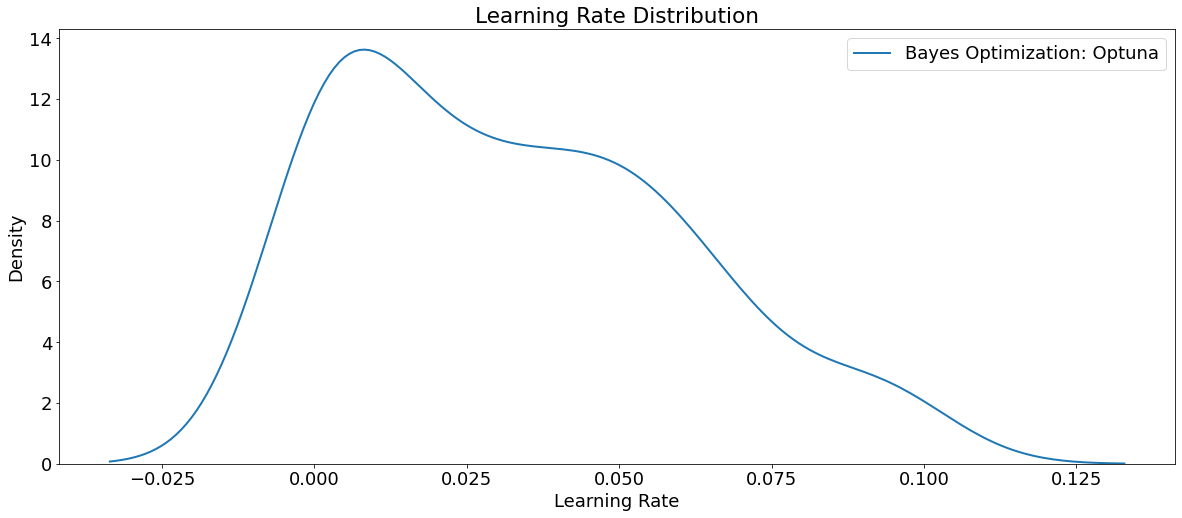

In [ ]:
# Density plots of the learning rate distributions 
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label = 'Bayes Optimization: Optuna', 
            linewidth = 2)
plt.legend(loc = 1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

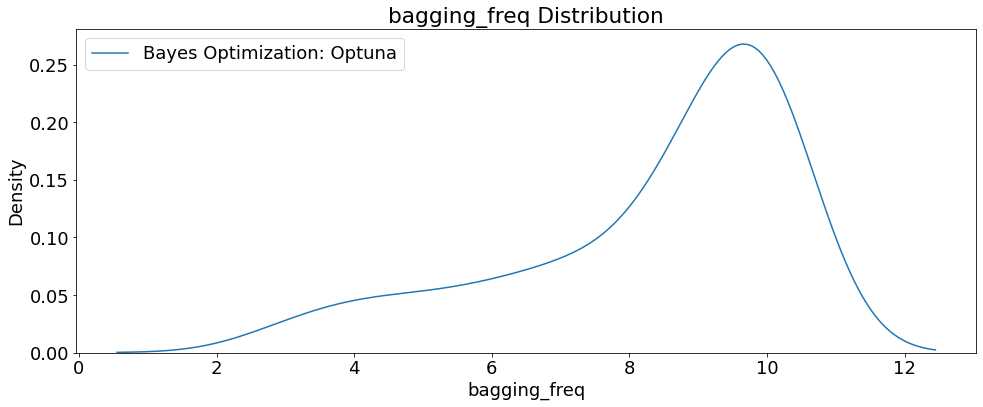

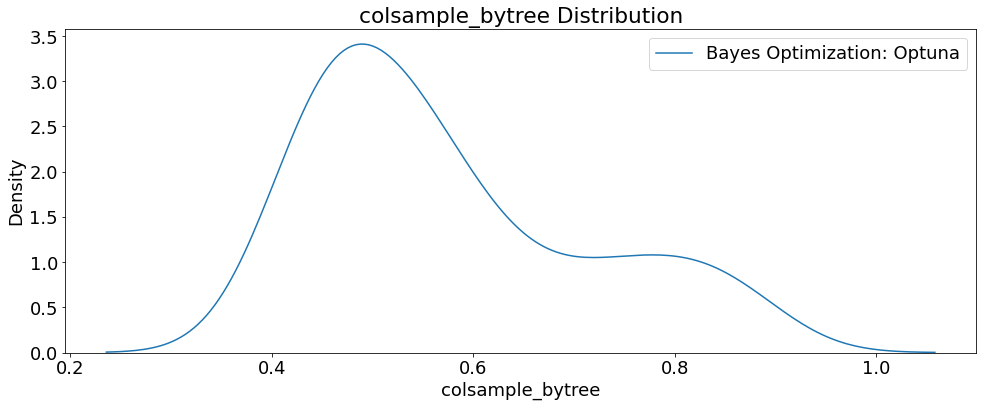

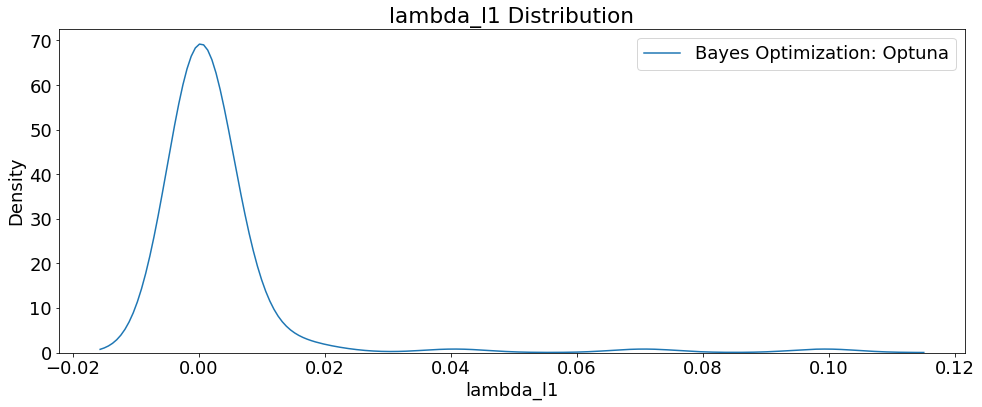

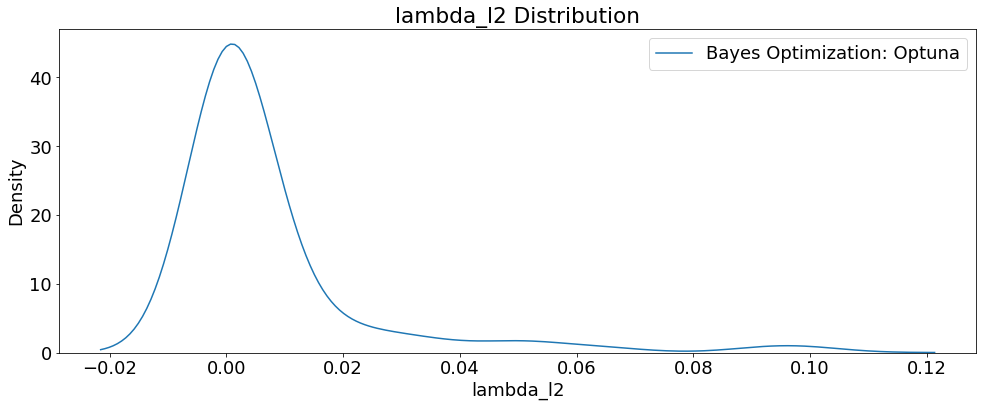

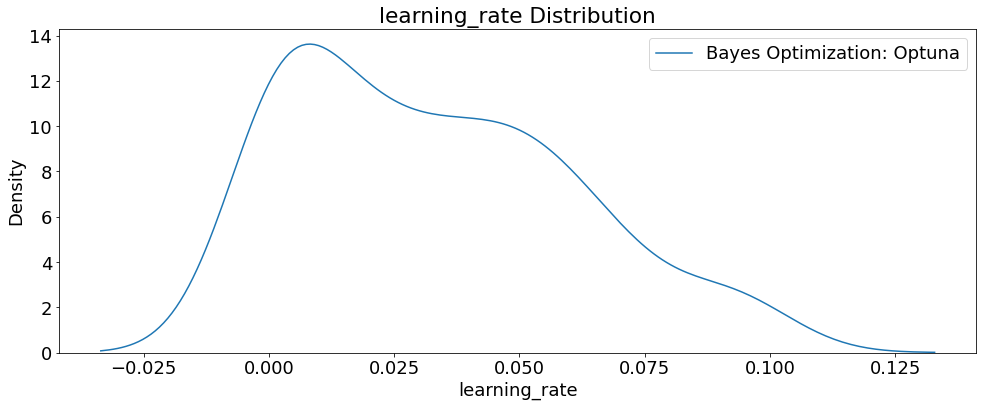

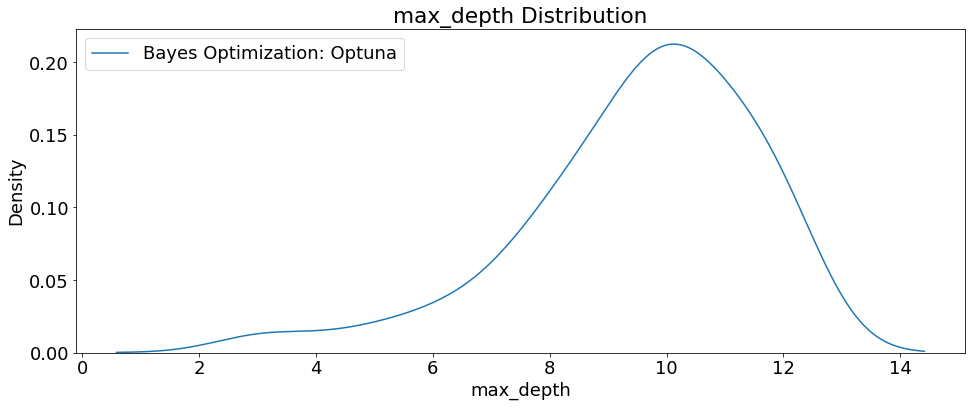

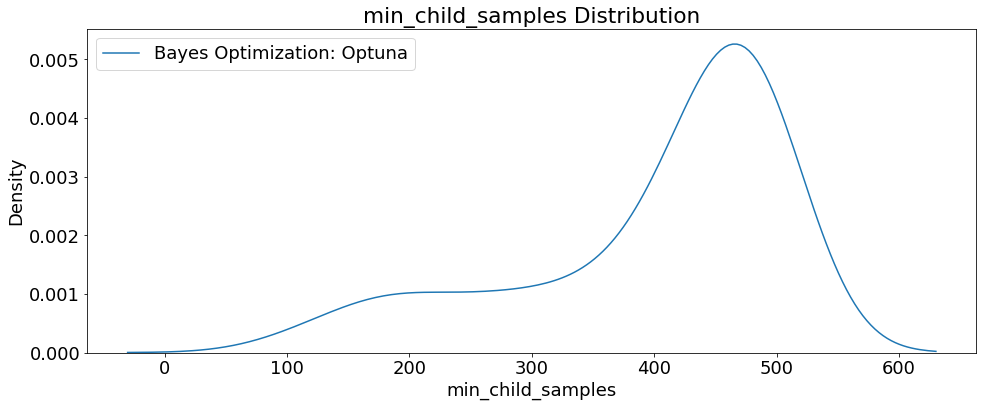

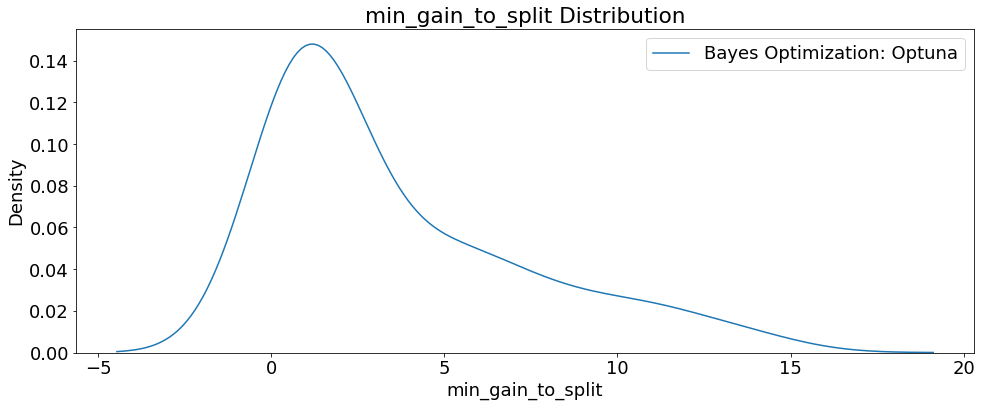

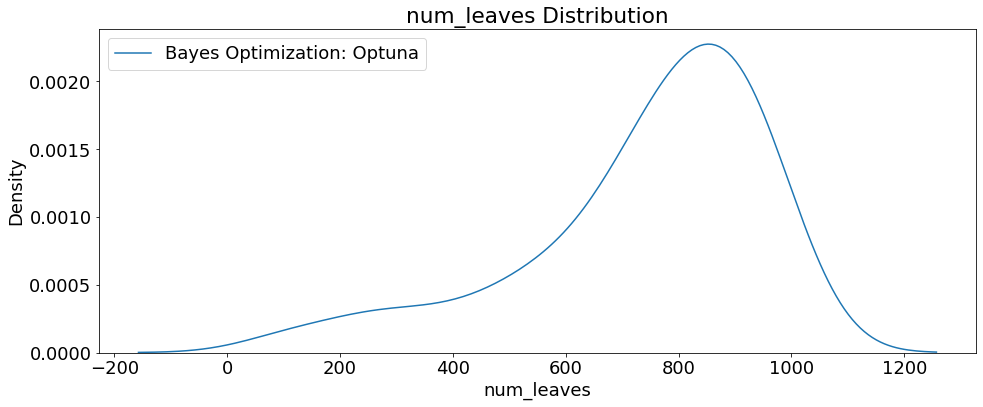

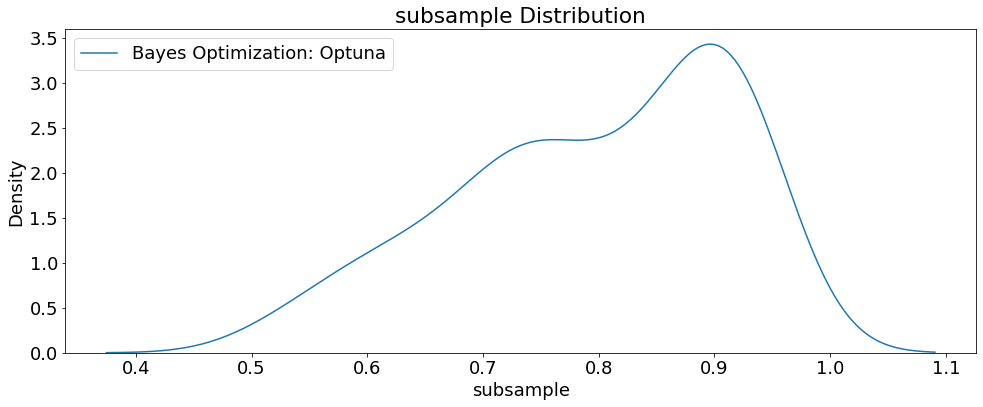

In [ ]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning

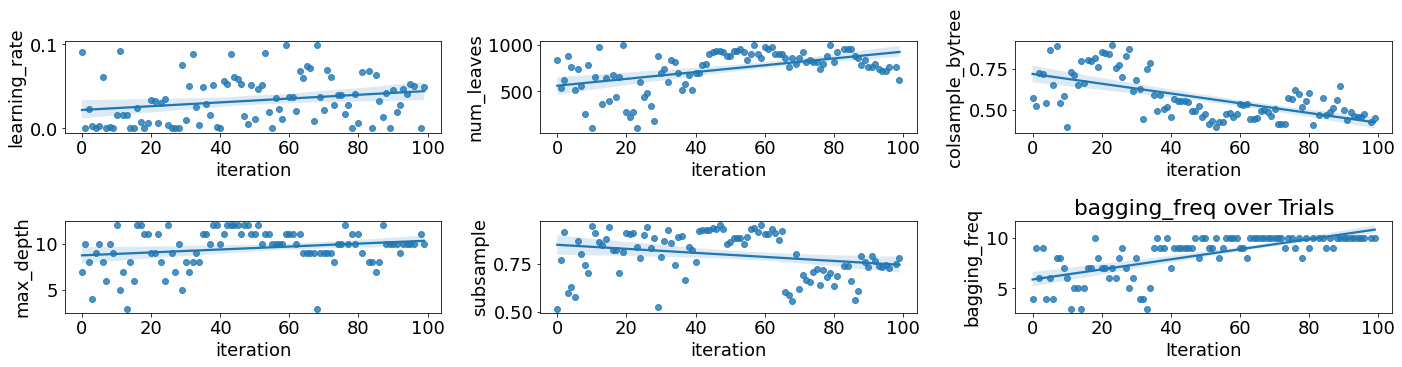

In [ ]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(2, 3, figsize = (20, 5))
i = 0
axs = axs.flatten()
for i, hpo in enumerate(['learning_rate', 'num_leaves', 'colsample_bytree', 
                         'max_depth', 'subsample', 'bagging_freq']): 

                        # Scatterplot
                         sns.regplot('iteration', hpo, data = trials_df, ax = axs[i]) 
axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo),  
                                    title = '{} over Trials'.format(hpo))

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



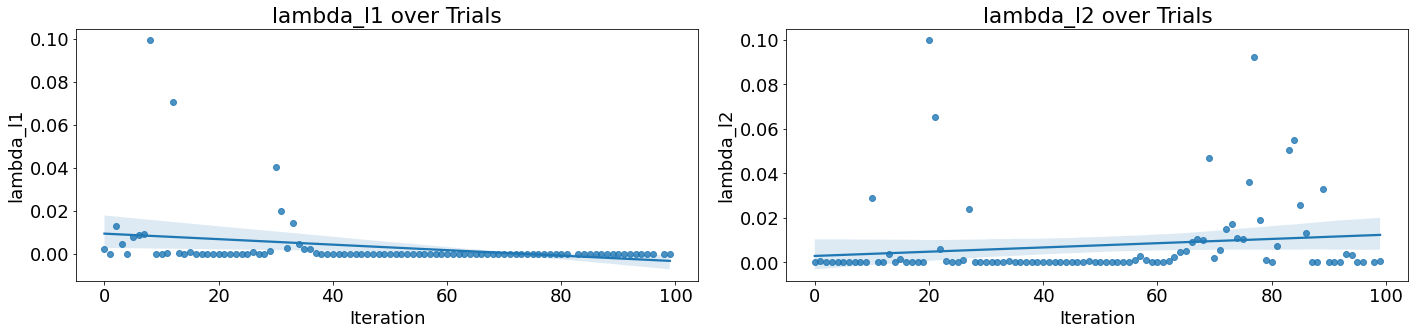

In [ ]:
# Scatterplot of regularization hyperparameters)
fig, axs = plt.subplots(1, 2, figsize = (20, 5))
i = 0
for i, hpo in enumerate(['lambda_l1', 'lambda_l2']):
        # Scatterplot
        sns.regplot('iteration', hpo, data = trials_df, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/ReviewStars/Model_PKL/

study = joblib.load('lightGBM_Optuna_100_GPU_balancedSizeSentiment.pkl')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/ReviewStars/Model_PKL


In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/ReviewStars/Model_Explanations/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/ReviewStars/Model_Explanations


In [ ]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_lightGBM_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [ ]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_lightGBM_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [ ]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params['random_state'] = seed_value
params['metric'] = 'binary_error'
params

{'bagging_freq': 10,
 'colsample_bytree': 0.4757810009639875,
 'lambda_l1': 1.705801617730491e-08,
 'lambda_l2': 6.230256501405558e-05,
 'learning_rate': 0.05021079866201762,
 'max_depth': 10,
 'metric': 'binary_error',
 'min_child_samples': 440,
 'min_gain_to_split': 0.7203173054362948,
 'n_estimators': 490,
 'num_leaves': 760,
 'random_state': 42,
 'subsample': 0.729486406738026}

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/ReviewStars/Model_PKL/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/ReviewStars/Model_PKL


In [ ]:
label = df[['stars_reviews']]

features = df.cleanReview

In [ ]:
# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, stratify=label)

In [ ]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [ ]:
# Re-create the best model and train on the training data
best_model = lgb.LGBMClassifier(**params, verbosity=-1)

# Fit the model
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'lightGBM_HPO_Optuna_trials100_GPU_balancedSizeSentiment.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('lightGBM_HPO_Optuna_trials100_GPU_balancedSizeSentiment.pkl')
# print(model)
# =============================================================================

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Warning] lambda_l2 is set=6.230256501405558e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.230256501405558e-05
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] lambda_l1 is set=1.705801617730491e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.705801617730491e-08
[LightGBM] [Warning] min_gain_to_split is set=0.7203173054362948, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.7203173054362948


In [ ]:
print('Results from lightGBM HPO Optuna 100 GPU trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')

print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from lightGBM HPO Optuna 100 GPU trials:


Classification Report: Train
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95    331949
         1.0       0.96      0.95      0.95    331950

    accuracy                           0.95    663899
   macro avg       0.95      0.95      0.95    663899
weighted avg       0.95      0.95      0.95    663899



Confusion matrix: Train
[[317462  14487]
 [ 15516 316434]]


Classification Report: Test
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94     82988
         1.0       0.94      0.94      0.94     82987

    accuracy                           0.94    165975
   macro avg       0.94      0.94      0.94    165975
weighted avg       0.94      0.94      0.94    165975



Confusion matrix: Test
[[78161  4827]
 [ 5235 77752]]


Accuracy score: train: 0.955, test: 0.939
Precision score: train: 0.956, test: 0.942
Recall score: train: 0.953, test

In [ ]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/ReviewStars/trialOptions/

# Access results
trials_df = pd.read_csv('lightGBM_Optuna_100_GPU_balancedSizeSentiment.csv')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/lightGBM/ReviewStars/trialOptions


In [ ]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.93938 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    96
logloss                                 0.15543
datetime_start       2022-05-13 18:54:42.680881
datetime_complete    2022-05-13 18:57:38.221153
duration                 0 days 00:02:55.540272
bagging_freq                               10.0
colsample_bytree                       0.475781
lambda_l1                                   0.0
lambda_l2                              0.000062
learning_rate                          0.050211
max_depth                                  10.0
min_child_samples                         440.0
min_gain_to_split                      0.720317
n_estimators                              490.0
num_leaves                                760.0
subsample                              0.729486
state                                  COMPLETE
Name: 0, dtype: object
